/tmp/ipython-input-8-221661347.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start="2019-06-01", end="2024-06-01", progress=False)['Close']


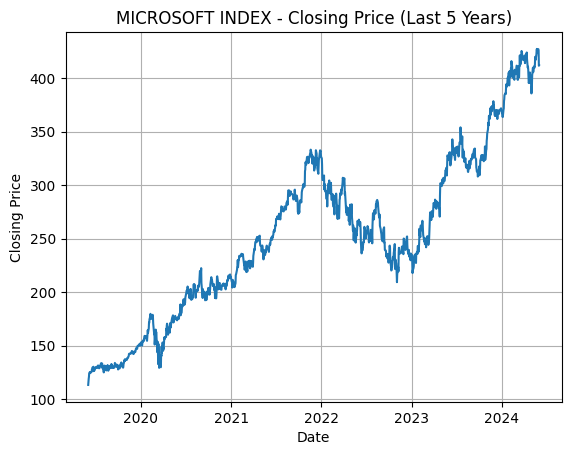

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Download NIFTY data
stock_symbol = 'MSFT'
stock_data = yf.download(stock_symbol, start="2019-06-01", end="2024-06-01", progress=False)['Close']

plt.plot(stock_data)
plt.title("MICROSOFT INDEX - Closing Price (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid()
plt.show()


In [9]:
# Train-Test Split
train_size = int(len(stock_data) * 0.8)
train_stock = stock_data[:train_size]
test_stock = stock_data[train_size:]

# Normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_stock_scaled = scaler.fit_transform(train_stock.values.reshape(-1, 1))
test_stock_scaled = scaler.transform(test_stock.values.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Parameters
seq_length = 60

# Create sequences
X_train, y_train = create_sequences(train_stock_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)
test_combined = np.concatenate((train_stock_scaled[-seq_length:], test_stock_scaled))

# Recreate test sequences from combined data
X_test, y_test = create_sequences(test_combined, seq_length)

# Reshape for LSTM input
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Scale back actual test values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Adjust the index to match full test period
adjusted_test_index = test_stock.index[:len(predictions)]


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0655
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0020
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0018
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0017
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0017
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0016
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0017
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0015
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0014
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0012
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0013
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0013
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0013
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0017
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0012
Epoch 16/50
60/

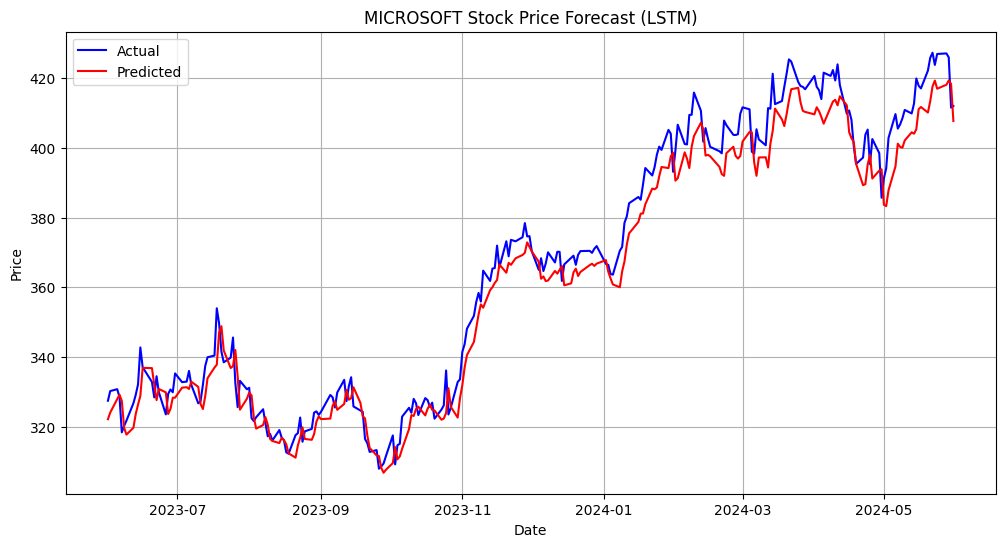

RMSE: 6.864
MAPE: 1.542%


In [10]:
plt.figure(figsize=(12, 6))
plt.plot(adjusted_test_index, y_test_actual, label="Actual", color="blue")
plt.plot(adjusted_test_index, predictions, label="Predicted", color="red")
plt.legend()
plt.title("MICROSOFT Stock Price Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


# Evaluation Metrics
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_actual, predictions) * 100

# Print Results
#print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}%")